# Tic-Tac-Toe with Policy Gradient

Julia L. Wang | ECE324 Mini-Project 3

## Initialization

In [12]:
## From starter code
# import statements
from __future__ import print_function
from collections import defaultdict
from itertools import count
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions
from torch.autograd import Variable
import matplotlib.pyplot as plt
np.random.seed(328)
random.seed(328)
torch.manual_seed(328)

In [ ]:
def load_weights(policy, episode):
    """Load saved weights"""
    weights = torch.load("policy-%d.pkl" % episode)
    policy.load_state_dict(weights)

## Part 1: The Environment

In [ ]:
## Environment class
class Environment(object):
    """
    The Tic-Tac-Toe Environment
    """
    # possible ways to win
    win_set = frozenset([(0,1,2), (3,4,5), (6,7,8), # horizontal
                         (0,3,6), (1,4,7), (2,5,8), # vertical
                         (0,4,8), (2,4,6)])         # diagonal
    # statuses
    STATUS_VALID_MOVE = 'valid'
    STATUS_INVALID_MOVE = 'inv'
    STATUS_WIN = 'win'
    STATUS_TIE = 'tie'
    STATUS_LOSE = 'lose'
    STATUS_DONE = 'done'

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset the game to an empty board."""
        self.grid = np.array([0] * 9) # grid
        self.turn = 1                 # whose turn it is
        self.done = False             # whether game is done
        return self.grid

    def render(self):
        """Print what is on the board."""
        map = {0:'.', 1:'x', 2:'o'} # grid label vs how to plot
        print(''.join(map[i] for i in self.grid[0:3]))
        print(''.join(map[i] for i in self.grid[3:6]))
        print(''.join(map[i] for i in self.grid[6:9]))
        print('====')

    def check_win(self):
        """Check if someone has won the game."""
        for pos in self.win_set:
            s = set([self.grid[p] for p in pos])
            if len(s) == 1 and (0 not in s):
                return True
        return False

    def step(self, action):
        """Mark a point on position action."""
        assert type(action) == int and action >= 0 and action < 9
        # done = already finished the game
        if self.done:
            return self.grid, self.STATUS_DONE, self.done
        # action already have something on it
        if self.grid[action] != 0:
            return self.grid, self.STATUS_INVALID_MOVE, self.done
        # play move
        self.grid[action] = self.turn
        if self.turn == 1:
            self.turn = 2
        else:
            self.turn = 1
        # check win
        if self.check_win():
            self.done = True
            return self.grid, self.STATUS_WIN, self.done
        # check tie
        if all([p != 0 for p in self.grid]):
            self.done = True
            return self.grid, self.STATUS_TIE, self.done
        return self.grid, self.STATUS_VALID_MOVE, self.done

    def random_step(self):
        """Choose a random, unoccupied move on the board to play."""
        pos = [i for i in range(9) if self.grid[i] == 0]
        move = random.choice(pos)
        return self.step(move)

    def play_against_random(self, action):
        """Play a move, and then have a random agent play the next move."""
        state, status, done = self.step(action)
        if not done and self.turn == 2:
            state, s2, done = self.random_step()
            if done:
                if s2 == self.STATUS_WIN:
                    status = self.STATUS_LOSE
                elif s2 == self.STATUS_TIE:
                    status = self.STATUS_TIE
                else:
                    raise ValueError("???")
        return state, status, done

The Tic-Tac-Toe grid is represented as an np array with 9 elements, which is initiated to 0s upon starting the game. 

The attribute *turn* is either 1 or 2 for the 2 players, indicating whose turn it is. Upon one player making a move, the turn attribute will switch to the other player.

The attribute *done* is either True or False, indicating whether the game has been completed. This occurs when either a player wins or the entire board has been filled. 

### Playing a game against myself

In [ ]:
e = Environment()
e.step(0) # X
# e.render()
e.step(4) # O
e.render()
e.step(1) # X
# e.render()
e.step(2) # O
e.render()
e.step(6) # X
# e.render()
e.step(3) # O
e.render()
e.step(5) # X
# e.render()
e.step(8) # O
e.render()
e.step(7) # X

x..
.o.
...
====
xxo
.o.
...
====
xxo
oo.
x..
====
xxo
oox
x.o
====


(array([1, 1, 2, 2, 2, 1, 1, 1, 2]), 'tie', True)

### Playing a game against random agent

In [ ]:
e = Environment()
e.play_against_random(4)
e.render()

..o
.x.
...
====


In [ ]:
e.play_against_random(0)
e.render()

xoo
.x.
...
====


In [ ]:
e.play_against_random(8)
e.render()

xoo
.x.
..x
====


In [ ]:
e.play_against_random(2) #game over

(array([1, 2, 2, 0, 1, 0, 0, 0, 1]), 'done', True)

## Part 2: Policy

Policy class is a neural network with one hidden layer. 

In [ ]:
class Policy(nn.Module):
    """
    The Tic-Tac-Toe Policy
    """
    def __init__(self, input_size=27, hidden_size=64, output_size=9):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # fully connected layers
        self.fc2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.softmax(self.fc2(x)) # so probabilities sum to 1
        return x


In [ ]:
def select_action(policy, state):
    """Samples an action from the policy at the state."""
    state = torch.from_numpy(state).long().unsqueeze(0)
    state = torch.zeros(3,9).scatter_(0,state,1).view(1,27)
    pr = policy(Variable(state))
    m = torch.distributions.Categorical(pr) 
    action = m.sample()
    log_prob = torch.sum(m.log_prob(action))
    return int(action.data[0]), log_prob

The state is represented as a 27-dimensional vector for the 3x3 board. This is because for each position on the board (9 positions total), there are 3 possibilites: no one has occupied it, player 1 has occupied it, or player 2 has occupied it. This leads to 3x3 x 3 = 27 dimensions.


The output of the policy is a 9 dimensional vector, each corresponding to the 9 positions of the board. The vector is a vector of probabilities of choosing the respective position which is updated as the policy is trained. 

The policy is stochastic since it can be represented as a family of probability distributions. Each of the 9 values of the output represents the probability of choosing it, which is outputted by the softmax function. It is not deterministic since there is an element of unpredictability of the next move.

## Part 3: Policy Gradient

Computing returns

In [ ]:
def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
      @param rewards: list of floats, where rewards[t] is the reward
                      obtained at time step t
      @param gamma: the discount factor
      @returns list of floats representing the episode's returns
          G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... 

    >>> compute_returns([0,0,0,1], 1.0)
    [1.0, 1.0, 1.0, 1.0]
    >>> compute_returns([0,0,0,1], 0.9)
    [0.7290000000000001, 0.81, 0.9, 1.0]
    >>> compute_returns([0,-0.5,5,0.5,-10], 0.9)
    [-2.5965000000000003, -2.8850000000000002, -2.6500000000000004, -8.5, -10.0]
    """
    G_t = [] # final list of floats
    for i in range(len(rewards)):
      r_t = 0 # reward
      exp = 0 # exponent of gamma
      for j in range(i, len(rewards)):
        r_t += (gamma**exp) * rewards[j]
        exp += 1  # increment exponent of gamma each time
      G_t.append(r_t)
  
    return G_t

# compute_returns([0,0,0,1], 1.0)
# compute_returns([0,0,0,1], 0.9)
# compute_returns([0,-0.5,5,0.5,-10], 0.9)

In [ ]:
def finish_episode(saved_rewards, saved_logprobs, gamma=1.0):
    """Samples an action from the policy at the state."""
    policy_loss = []
    returns = compute_returns(saved_rewards, gamma)
    returns = torch.Tensor(returns)
    # subtract mean and std for faster training
    returns = (returns - returns.mean()) / (returns.std() +
                                            np.finfo(np.float32).eps)
    for log_prob, reward in zip(saved_logprobs, returns):
        policy_loss.append(-log_prob * reward)

    # print(len(policy_loss))
    # print(policy_loss)

    policy_loss = torch.stack(policy_loss).sum()
    # print(policy_loss)
    # print(type(policy_loss))

    policy_loss.backward(retain_graph=True)
    # note: retain_graph=True allows for multiple calls to .backward()
    # in a single step


**Why can we not update weights in the middle of an episode?** The backward pass cannot update weights until the entire episode due to how the finish_episode function computes the policy loss. Since the policy_loss list is appended with negative log probabilities * reward at each time step, it must finish the episode to obtain its final value. Only after this do we obtain it's values and run the backward pass to update the weights. 

## Part 4: Rewards

In [ ]:
def get_reward(status):
    """Returns a numeric given an environment status."""
    return {
            Environment.STATUS_VALID_MOVE  : 10, # empty position, game continues
            Environment.STATUS_INVALID_MOVE: -10, # move ignored
            Environment.STATUS_WIN         : 100, # valid and winning move
            Environment.STATUS_TIE         : 0, # valid and no more positions 
            Environment.STATUS_LOSE        : -50  # opponent wins
    }[status]

### Justification of rewards

I chose valid move and winning the game to have positive rewards. Similarly, an invalid move and losing the game has negative rewards. Since I wanted to mostly value winning/losing the game over making invalid/valid moves, I weighted the magnitude of winning 10x more than making a valid/invalid move. I also wanted the value of winning to be greater than the value of losing, so I made it double in magnitude. Therefore, the reward for winning and losing is 100 and -50 respectively, and the reward for valid and invalid move is the same at +/-10 respectively. I decided that the game ending in a tie would have zero reward since a tie is neutral and is the middle ground where neither player is rewarded.

## Part 5: Training

In [23]:
## Training loop
def train(policy, env, gamma=1.0, log_interval=1000):
    """Train policy gradient."""
    optimizer = optim.Adam(policy.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10000, gamma=0.9)
    running_reward = 0

    # additionally -- 
    # for plotting 
    x = []   # episodes
    y = []   # average return

    for i_episode in range(75000):
        saved_rewards = []
        saved_logprobs = []
        state = env.reset()
        done = False

        while not done:
            action, logprob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
            reward = get_reward(status)
            saved_logprobs.append(logprob)
            saved_rewards.append(reward)

        R = compute_returns(saved_rewards)[0]
        running_reward += R
        
        finish_episode(saved_rewards, saved_logprobs, gamma)
        
        if i_episode % log_interval == 0:
            print('Episode {}\tAverage return: {:.2f}'.format(
                i_episode,
                running_reward / log_interval))
            
            x.append(i_episode) # add to list of episodes
            y.append(running_reward/log_interval) # add to list of average return

            running_reward = 0 # reset reward
        
        if i_episode % (log_interval) == 0:
            torch.save(policy.state_dict(),
                       "policy-%d.pkl" % i_episode)

        if i_episode % 1 == 0: # batch_size
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    return x, y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Episode 0	Average return: 0.13
Episode 1000	Average return: 30.25
Episode 2000	Average return: 53.91
Episode 3000	Average return: 62.56
Episode 4000	Average return: 65.76
Episode 5000	Average return: 61.30
Episode 6000	Average return: 69.39
Episode 7000	Average return: 66.92
Episode 8000	Average return: 71.46
Episode 9000	Average return: 71.69
Episode 10000	Average return: 69.77
Episode 11000	Average return: 77.61
Episode 12000	Average return: 70.31
Episode 13000	Average return: 79.34
Episode 14000	Average return: 81.18
Episode 15000	Average return: 74.11
Episode 16000	Average return: 81.29
Episode 17000	Average return: 82.21
Episode 18000	Average return: 83.86
Episode 19000	Average return: 83.35
Episode 20000	Average return: 75.81
Episode 21000	Average return: 80.59
Episode 22000	Average return: 81.54
Episode 23000	Average return: 86.45
Episode 24000	Average return: 85.29
Episode 25000	Average return: 83.21
Episode 26000	Average return: 82.34
Episode 27000	Average return: 84.52
Episod

Text(0.5, 1.0, 'Training Return')

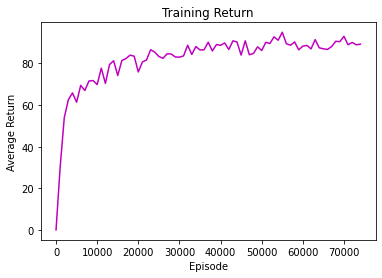

In [45]:
## Training
# initializing environment and policy
e = Environment()
pol = Policy()
eps, avg = train(pol, e) # training

plt.plot(eps, avg, color="m")
plt.xlabel("Episode")
plt.ylabel("Average Return")
plt.title("Training Return")

### Hyperparameter Tuning

Finding the optimal number of hidden units in the hidden layer. 

In [ ]:
## Modify training loop to return the maximum average return and episode it occurred
## Training loop

def train_for_tune(policy, env, gamma=1.0, log_interval=1000):
    """Train policy gradient."""
    optimizer = optim.Adam(policy.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10000, gamma=0.9)
    running_reward = 0

    # additionally -- 
    # for measuring hyperparameter performance
    max_avg = 0       # the maxiumum average
    max_episode = 0   # the episode it occurred

    for i_episode in range(75000):
        saved_rewards = []
        saved_logprobs = []
        state = env.reset()
        done = False

        while not done:
            action, logprob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
            reward = get_reward(status)
            saved_logprobs.append(logprob)
            saved_rewards.append(reward)

        R = compute_returns(saved_rewards)[0]
        running_reward += R
        
        finish_episode(saved_rewards, saved_logprobs, gamma)
        
        if i_episode % log_interval == 0:
            avg = running_reward / log_interval
            # print('Episode {}\tAverage return: {:.2f}'.format(
            #     i_episode,
            #     avg))
            if avg > max_avg:
              max_avg = avg
              max_episode = i_episode
            
            running_reward = 0 # reset reward
        
        if i_episode % (log_interval) == 0:
            torch.save(policy.state_dict(),
                       "policy-%d.pkl" % i_episode)

        if i_episode % 1 == 0: # batch_size
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    return max_avg, max_episode

In [ ]:
## Hyperparameter tuning
h = [16, 32, 48, 64, 96]
for num in h:
  e = Environment()
  pol = Policy(hidden_size = num)
  maxavg, maxep = train_for_tune(pol, e) # training
  print("For ", num, "hidden units, the maxiumum average was ", maxavg, "at episode ", maxep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


For  16 hidden units, the maxiumum average was  8.365 at episode  67000
For  32 hidden units, the maxiumum average was  8.911 at episode  49000
For  48 hidden units, the maxiumum average was  8.768 at episode  25000
For  64 hidden units, the maxiumum average was  8.924 at episode  67000
For  96 hidden units, the maxiumum average was  8.775 at episode  72000


| Num hidden units | Maxiumum Average | Episode of Max Average |
|----------------|----------|-------------|
| 16 | 83.65 | 67000 |
| 32 | 89.11 | 49000 |
| 48 | 87.68 | 25000 |
| 64 | 89.24 | 67000 |
| 96 | 87.75 | 72000 |

From the results above, it appears like a choice of 32 and 64 hidden units yields the most optimal average return. Looking at the episode of occurance, the maximum average return is reached fastest for 48 hidden units, at episode 25000 out of the 75000 total. 32 hidden units was the second fastest to reach the maximum at episode 49000. Moving forward, the hidden unit size of 32 was used since the maximum average was similar to 64 hidden units over less episodes. 

In [38]:
## retraining with converged hyperparameter
e = Environment()
pol = Policy(hidden_size = 34)
x, y = train(pol, e)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Episode 0	Average return: 0.04
Episode 1000	Average return: 31.49
Episode 2000	Average return: 47.74
Episode 3000	Average return: 61.25
Episode 4000	Average return: 63.41
Episode 5000	Average return: 61.31
Episode 6000	Average return: 70.30
Episode 7000	Average return: 69.91
Episode 8000	Average return: 75.13
Episode 9000	Average return: 68.66
Episode 10000	Average return: 71.21
Episode 11000	Average return: 69.80
Episode 12000	Average return: 75.54
Episode 13000	Average return: 71.89
Episode 14000	Average return: 77.47
Episode 15000	Average return: 75.06
Episode 16000	Average return: 74.65
Episode 17000	Average return: 79.80
Episode 18000	Average return: 79.59
Episode 19000	Average return: 76.46
Episode 20000	Average return: 82.24
Episode 21000	Average return: 84.64
Episode 22000	Average return: 86.02
Episode 23000	Average return: 87.45
Episode 24000	Average return: 87.48
Episode 25000	Average return: 81.28
Episode 26000	Average return: 88.92
Episode 27000	Average return: 86.95
Episod

### Playing invalid moves

Determining the episode that the agent learned how to stop playing invalid moves. 

In [28]:
## Returning when invalid moves are stopped

invalid = -328
count_zeroes = 0
log_interval = 1000

for i_episode in range(0, 75000, 1000):
    # get the results from every 1000 episodes
    load_weights(pol, i_episode)

    state = e.reset()
    done = False

    # break the loop if invalid has been 0 for 3 episodes
    if count_zeroes >= 3:
      break
    
    invalid = 0 # reset invalid per episode

    while not done:
        action, logprob = select_action(pol, state)
        state, status, done = e.play_against_random(action)

        # update invalid for each invalid move played
        if status == e.STATUS_INVALID_MOVE:
          invalid += 1
    
    if i_episode % log_interval == 0:
        print('Episode {}\t Invalid moves for episode: {}'.format(
            i_episode,
            invalid))
        
        if invalid == 0:
          count_zeroes += 1 # increment count
        else:
          count_zeroes = 0 #reset
        

Episode 0	 Invalid moves for episode: 7
Episode 1000	 Invalid moves for episode: 1
Episode 2000	 Invalid moves for episode: 3
Episode 3000	 Invalid moves for episode: 0
Episode 4000	 Invalid moves for episode: 1
Episode 5000	 Invalid moves for episode: 0
Episode 6000	 Invalid moves for episode: 1
Episode 7000	 Invalid moves for episode: 0
Episode 8000	 Invalid moves for episode: 0
Episode 9000	 Invalid moves for episode: 3
Episode 10000	 Invalid moves for episode: 0
Episode 11000	 Invalid moves for episode: 1
Episode 12000	 Invalid moves for episode: 0
Episode 13000	 Invalid moves for episode: 0
Episode 14000	 Invalid moves for episode: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


The episode that the agent learned to stop playing invalid moves was around episode 14000. This was found by counting the number of invalid moves per episode, which was recorded every 1000 episodes.  I inserted a break statement for when the invalid moves was constantly 0 for 3 of the displayed episodes (3000 eps). As shown above, the agent stopped playing invalid moves around episode 14000.

### Playing against random player

In [42]:
## Playing 100 games against random
load_weights(pol, 70000)

# Choosing 5 random games to print
games_to_display = [16, 32, 48, 64, 80]
wins = 0    #initializing total counts
losses = 0
ties = 0

for game in range(100):
  # 100 games
  grid = e.reset() # reset game state
  if game in games_to_display:
    print("Playing game ", game)

  while e.done == False:
    # play until the game is finished
    action, logprob = select_action(pol, grid)
    grid, status, done = e.play_against_random(action)

    # display game if in the 5 random ones
    if game in games_to_display:
      e.render()
  if status == 'win':
    wins += 1
  elif status == 'lose':
    losses += 1
  elif status == 'tie':
    ties += 1

print("Wins: ", wins, " Losses: ", losses, " Ties: ", ties)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Playing game  16
...
o..
x..
====
o..
o.x
x..
====
ox.
o.x
xo.
====
ox.
oxx
xoo
====
oxx
oxx
xoo
====
Playing game  32
...
...
xo.
====
...
o.x
xo.
====
.x.
o.x
xoo
====
.xo
oxx
xoo
====
xxo
oxx
xoo
====
Playing game  48
o..
...
x..
====
ox.
...
xo.
====
ox.
ox.
xo.
====
ox.
oxo
xox
====
oxx
oxo
xox
====
Playing game  64
.o.
...
x..
====
.o.
..x
xo.
====
.o.
oxx
xo.
====
xoo
oxx
xo.
====
xoo
oxx
xox
====
Playing game  80
...
o..
x..
====
.o.
o.x
x..
====
xo.
o.x
xo.
====
xo.
oxx
xoo
====
xox
oxx
xoo
====
Wins:  56  Losses:  7  Ties:  37


Wins:  59  Losses:  9  Ties:  32

### Agent strategies

It seems like the agent always chooses the bottom left position to start the game. Although it is not the optimal choice (the middle position), it makes sense since it was trained against a random player and depends wholly on the training. Perhaps training it on a different agent or training it for more epochs would result in choosing the middle position. Moreover, it appears as if the agent has not learned to go for a diagonal win given its first choice of position (for the middle position and upper right). It appears as if the agent tends to choose a position in the same row as the opponents previous move (see game 80). This makes sense since it is working to prevent the opponent from a horizontal win. Due to the randomization of the agent it trained against, the random agent could have gotten more horizontal wins which the agent trained against, and therefore, the agent accounts against horizontal wins more.

## Part 6: Win Rate over Episodes

Exploring win-lose-tie rates throughout training by plotting the graph. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


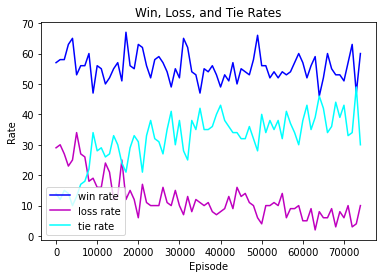

In [39]:
wins, losses, ties, eps, x, y = [], [], [], [], [], [] #train_for_rates(pol, e)

log_interval = 1000
counter, win_count, tie_count, loss_count = 0, 0, 0, 0

for i_episode in range(0, 75000, 1000):
    load_weights(pol, i_episode)

    for i in range(100):
      state = e.reset()
      done = False

      while not done:
          action, logprob = select_action(pol, state)
          state, status, done = e.play_against_random(action)

      if status == 'win':
        win_count += 1
      elif status == 'lose':
        loss_count += 1
      elif status == 'tie':
        tie_count += 1

    wins.append(win_count)
    losses.append(loss_count)
    ties.append(tie_count)
    eps.append(i_episode)
    win_count, loss_count, tie_count = 0, 0, 0


plt.plot(eps, wins, color = 'b')
plt.plot(eps, losses, color='m')
plt.plot(eps, ties, color='cyan') 
plt.title("Win, Loss, and Tie Rates")
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.legend(['win rate', 'loss rate', 'tie rate'])
plt.show()

The graph above depicts the total win/loss/ties over 100 games during training. Overall, the loss rate decreased over training which indicates that the model learned to not lose. However, it is interesting to see that the win rate was pretty constant and the rate of ties increased at the beginning. Only at the beginning 30000 epochs was there significant change where the losses rapidly decreased and the ties increased. One future improvement is to change the model reward such that ties are given less reward, which could potentially decrease the tie rate, subsequently, increasing the number of wins.

## Part 7: First Move Distribution over Episodes


In [43]:
# Learned distribution over first move
## loading weights from pickle
load_weights(pol, 70000)

## from select action
state = e.reset()
state = torch.from_numpy(state).long().unsqueeze(0)
state = torch.zeros(3,9).scatter_(0,state,1).view(1,27)
pr = pol(Variable(state)).data.numpy().flatten()

## first move distribution
for i in range(9):
  print("Position ", i+1, " | ", '{:.3g}'.format(pr[i]))

Position  1  |  6.82e-08
Position  2  |  3.46e-07
Position  3  |  4.42e-11
Position  4  |  9.21e-10
Position  5  |  2.84e-07
Position  6  |  3.35e-05
Position  7  |  1
Position  8  |  2.9e-09
Position  9  |  9.17e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


As noted in Part 6, the model has learned to always make a move in the bottom left position (position 7). Although the position is not the ideal start that is the center position, it makes sense that the model would think so since it is trained against a random player. Changing the opponent being trained upon or running the model for more epochs could result in the model learning a new distribution and favoring the center position. However, in this case since training was randomized, it makes sense that the optimal starting position happened to be position 7.

### Distribution over training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


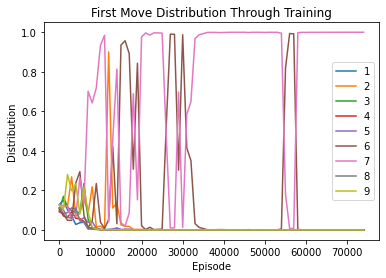

In [44]:
dist = [ [] for i in range(9)] # 1 list for each of the 9 positions
eps = [] # episodes

for i in range(0, 75000, 1000):
  load_weights(pol, i)
  state = e.reset()
  state = torch.from_numpy(state).long().unsqueeze(0)
  state = torch.zeros(3,9).scatter_(0,state,1).view(1,27)
  pr = pol(Variable(state)).data.numpy().flatten()
  for j in range(9):
    dist[j].append(pr[j])
  eps.append(i)

plt.plot(eps, dist[0])
plt.plot(eps, dist[1])
plt.plot(eps, dist[2])
plt.plot(eps, dist[3])
plt.plot(eps, dist[4])
plt.plot(eps, dist[5])
plt.plot(eps, dist[6])
plt.plot(eps, dist[7])
plt.plot(eps, dist[8])

plt.title("First Move Distribution Through Training")
plt.xlabel("Episode")
plt.ylabel("Distribution")
plt.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

Through the training process, the distribution changed as the model learned. Initially, it favored choosing position 2 and 6, and eventually settled with constantly choosing position 7 after around 60000 episodes. The most fluctuation was between choosing position 6 and 7 which began early on around episode 20000. By that point, the other positions were neglected and positions 6 and 7 were clearly favored by the agent.

## Part 8: Limitations


A significant limitation of the agent is how it consistently chooses position 7 as the starting position. As such, if the opponent takes the optimal middle position, the agent will have a difficult time winning since it will not be able to secure any diagonals, or a vertical/horizontal win with the middle position. The agent also tends to choose a position in the same row as the opponents previous move. This is indicative of the agent valuing blocking opponents possible horizontal wins over vertical or diagonals. As such, the agent does not consistently win since the opponent is randomized. Moreover, the agent does not seem to have an understanding of diagonal wins. Since the starting position is always bottom left at 7, a person would try and go for the middle position and upper right to secure a diagonal win. From the games printed, the agent values blocking an opponent horizontally over securing the diagonal.